In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2 

# Base GMKF

In [2]:
# In this notebook, we implemement the Gaussian Mixture Kalman Filter (GMKF) from Wills et. al. 2017

from scipy.stats import norm
from sklearn.mixture import GaussianMixture

class GMKF():
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max = 5) -> None:
        # mean trajectories
        self.x_mean = x_mean
        self.y_mean = y_mean
        self.v_mean = v_mean

        # time variable
        self.t = 0

        # these are also p(x_1 | y_1) or 1|1, or t|t
        self.N = 1 # initial number of mixture components for lateral component

        # Lateral component
        self.wx = np.array([1])
        self.mu_x = np.array([x_init])
        self.std_x = np.array([std_x])
        self.P_x = np.array([std_x**2])

        # Longitudinal component
        self.wy = np.array([1])
        self.mu_y = np.array([y_init, v_init]).T
        self.std_y = np.array([std_y])
        self.std_v = np.array([std_v])
        self.P_y = np.array([[std_y**2, 0], [0, std_v**2]])

        # Dynamics model
        # dynamics params is a tuple of alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v
        self.dynamics_params = dynamics_params 
        self.Nx = 3 # number of mixture components of the dynamics model for the lateral component
        self.N_max = N_max # maximum number of mixture components for the lateral component
        self.preliminary_pruning_weight_thres = 1e-3 # preliminary pruning weight threshold
        self.em_particles = 5_000 # number of particles for EM resampling of the mixture
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        self.C = np.array([[1, 0]])

        # Measurement model
        self.std_zx = np.array([std_zx])
        self.std_zy = np.array([std_zy])
        self.P_zx = np.array([std_zx**2])
        self.P_zy = np.array([std_zy**2])

        # Whole trajectory for smoothing
        self.mu_x_post = []
        self.P_x_post = []
        self.w_x_post = []
        self.mu_y_post = []
        self.P_y_post = []
        self.w_y_post = []

    def predict(self): # p(x_{t+1} | y_{1:t})
        print('Predicting t = {} -> {}'.format(self.t, self.t + 1))
        # predict the state of the system at the next time step
        # the prediction is a mixture of Gaussians

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # first, we compute the number of mixture components in the prediction t+1|1:t
        N_tPlus1_t = self.N * self.Nx # N is the number of components for t|t, Nx is the number of components for t+1|t or the dynamics model
        # then, we compute the means of each mixture component
        
        mu_x_pred = np.zeros(N_tPlus1_t)
        P_x_pred = np.zeros(N_tPlus1_t)
        w_x_pred = np.zeros(N_tPlus1_t)

        for s in range(self.N): # s is the index of t|t mixture
            for j in range(self.Nx): # j is the index of t+1|t mixture, or the dynamics model. j=0: left, j=1: center, j=2: right
                l = self.Nx * s + j # lth mixture component of t+1|1:t
                
                mu_x_pred[l] = (self.x_mean[self.t+1] - self.x_mean[self.t]) + self.mu_x[s] + self.dynamics_params[1 + 3*j] # 1, 4, 7 are the means of the dynamics model
                # in dynamics_params, the variances are at index 2, 5, 8
                P_x_pred[l] = self.P_x[s] + self.dynamics_params[2 + 3*j]**2 # the variance is the sum of the variances of the dynamics and the measurement, 2, 5, 8 are the variances of the dynamics model
                w_x_pred[l] = self.wx[s] * self.dynamics_params[0 + 3*j] # the weight is the product of the weights of the dynamics and the measurement

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # For longitudinal component, there is just one mixture component, so it's similar to a regular Kalman Filter
        # Position
        y_tPlus1_t = self.A @ self.mu_y + np.array([0, self.v_mean[self.t+1] - self.v_mean[self.t]]) # mean propagation of the state # 2x1
        P_tPlus1_t = self.A @ self.P_y @ self.A.T + self.B * self.dynamics_params[9]**2 # 9th index is the variance of the velocity
        w_tPlus1_t = self.wy[0]

        # at the end of the prediction step, we have 3x the number of mixture components for the state
        return mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t
    
    def update(self, zx, zy, prediction): # zx: the measured lateral (x) and longitudinal (y) position of the vehicle
        print('Updating t = {}'.format(self.t + 1))
        # the update follows Will's 2017 paper. 
        # prediction argument should come from self.predict()
        mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred = prediction

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # the number of posterior mixture components 
        N_tPlus1_t = mu_x_pred.shape[0]
        N_tPlus1_tPlus1 = N_tPlus1_t # because the measurement mixture has only one component
        mu_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        P_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        w_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)

        for l in range(N_tPlus1_t):
            # compute the predicted measurement covariance
            sigma_tl = P_x_pred[l] + self.P_zx[0] 
            # compute the Kalman gain
            K_tl = P_x_pred[l] / sigma_tl
            # compute the posterior mean
            ex = zx - mu_x_pred[l]
            mu_x_tPlus1_tPlus1[l] = mu_x_pred[l] + K_tl * ex
            # compute the posterior covariance
            P_x_tPlus1_tPlus1[l] = P_x_pred[l] - K_tl * P_x_pred[l]
            # compute the posterior weight
            w_x_tPlus1_tPlus1[l] = w_x_pred[l] * norm.pdf(ex, 0, np.sqrt(sigma_tl))
            
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)

        # ================== #
        # PRUNING OF MIXTURE COMPONENTS #
        # ================== #
        # The pruning of mixture components comprises of two steps:
        # 1. pruning of the mixture components with low weights
        # 2. pruning of the mixture components via resampling with EM

        # 1. pruning of the mixture components with low weights
        components_to_keep = np.where(w_x_tPlus1_tPlus1 > self.preliminary_pruning_weight_thres)[0]
        mu_x_tPlus1_tPlus1 = mu_x_tPlus1_tPlus1[components_to_keep]
        P_x_tPlus1_tPlus1 = P_x_tPlus1_tPlus1[components_to_keep]
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1[components_to_keep]
        
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)
        
        print('N. mix. components prned at LV1: ', N_tPlus1_tPlus1 - mu_x_tPlus1_tPlus1.shape[0])

        # 2. pruning of the mixture components via resampling with EM
        # if the result of the first pruning step is not satisfactory, we perform the second pruning step
        original_number_of_modes = mu_x_tPlus1_tPlus1.shape[0]
        if original_number_of_modes > self.N_max:
            # sample from the Gaussian mixture 10000 times
            particle_modes = np.random.choice(original_number_of_modes, 10000, p=w_x_tPlus1_tPlus1)
            particles = np.random.normal(mu_x_tPlus1_tPlus1[particle_modes], np.sqrt(P_x_tPlus1_tPlus1[particle_modes]))
            # fitting a Gaussian mixture to the samples
            gmm = GaussianMixture(n_components=self.N_max, covariance_type='diag', max_iter=1000, random_state=0).fit(particles.reshape(-1, 1))
            # extracting the parameters of the Gaussian mixture
            mu_x_tPlus1_tPlus1 = gmm.means_.flatten()
            P_x_tPlus1_tPlus1 = gmm.covariances_.flatten()
            w_x_tPlus1_tPlus1 = gmm.weights_.flatten()
            
            print('N. mix. components prned at LV2: ', original_number_of_modes - mu_x_tPlus1_tPlus1.shape[0])

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # Like said, the longitudinal component is similar to a regular Kalman Filter
        # so there is only one mixture component
        # compute the predicted measurement covariance
        sigma_yt = self.C @ P_y_pred @ self.C.T + self.P_zy[0] # scalar
        # compute the Kalman gain
        K_yt = P_y_pred @ self.C.T / sigma_yt # 2x1
        # compute the posterior mean
        ey = zy - self.C @ mu_y_pred
        mu_y_tPlus1_tPlus1 = mu_y_pred + (K_yt * ey).flatten() # 1x2
        # compute the posterior covariance
        P_y_tPlus1_tPlus1 = P_y_pred - K_yt @ self.C @ P_y_pred # 2x2
        # P_y_tPlus1_tPlus1 = P_y_pred - K_yt * sigma_yt * K_yt.T # 2x2 # original equation in the paper, but it's wrong?
        # compute the posterior weight
        w_y_tPlus1_tPlus1 = np.array([w_y_pred])

        return mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt

    def state_write(self, updaton):
        # updaton is the output of self.update()
        mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = updaton
        
        self.wx = w_x_tPlus1_tPlus1.flatten()
        self.mu_x = mu_x_tPlus1_tPlus1.flatten()
        self.P_x = P_x_tPlus1_tPlus1
        self.N = self.mu_x.shape[0]

        self.wy = w_y_tPlus1_tPlus1.flatten()
        self.mu_y = mu_y_tPlus1_tPlus1.flatten()
        self.P_y = P_y_tPlus1_tPlus1
        
        # save the posterior state values to the history
        self.mu_x_post.append(self.mu_x)
        self.P_x_post.append(self.P_x)
        self.w_x_post.append(self.wx)
        
        self.mu_y_post.append(self.mu_y)
        self.P_y_post.append(self.P_y)
        self.w_y_post.append(self.wy)

        # move the time step forward
        self.t += 1

# Two steps mixture components merging

In [3]:
def merge_components(alpha, mu, P, N_max = 5, threshold = 0.005, n_particles = 10_000):
    # First, we discard components with low weights
    components_to_keep = np.where(alpha > threshold)[0]
    mu = mu[components_to_keep]
    P = P[components_to_keep]
    alpha = alpha[components_to_keep]
    
    # Renormalize the weights
    alpha = alpha / np.sum(alpha)
    
    N_components_after_step_1 = mu.shape[0]
    
    print('Number of components pruned at LV1: ', N_components_after_step_1 - mu.shape[0])
    
    # Second, we use resampling with EM to merge 
    if N_components_after_step_1 > N_max:
        # sample from the Gaussian mixture 10000 times
        particle_modes = np.random.choice(N_components_after_step_1, n_particles, p=alpha)
        particles = np.random.normal(mu[particle_modes], np.sqrt(P[particle_modes]))
        # fitting a Gaussian mixture to the samples
        gmm = GaussianMixture(n_components=N_max, covariance_type='diag', max_iter=1000, random_state=0).fit(particles.reshape(-1, 1))
        # extracting the parameters of the Gaussian mixture
        mu = gmm.means_.flatten()
        P = gmm.covariances_.flatten()
        alpha = gmm.weights_.flatten()
        
    print('Number of components pruned at LV2: ', N_components_after_step_1 - mu.shape[0])
        
    return alpha, mu, P

In [4]:
def lse(weights):
    # Weight normalization by the Log Sum Exp trick
    w_max = np.max(weights)
    weights_n = np.zeros_like(weights)
    for i in range(weights.shape[0]):
        weights_n[i] = weights[i] - w_max - np.log(np.sum(np.exp(weights - w_max)))
    return weights_n

# SMOOTHIE

In [5]:
# define the SMOOTHIE class as a child class of GMKF
class SMOOTHIE(GMKF):
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max=5) -> None:
        super().__init__(x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max)
        # Informative prior for lateral component: unbounded uniform prior
        self.L_xs = np.array([0]) # BIF Information Matrix. Since x is scalar, L_xs is also scalar. The s stands for smoothed
        self.s_xs = np.array([0]) # BIF Information Vector 
        self.t_xs = np.array([0]) # BIF log-weight
        
        self.t_s = self.t # the variable which keeps track of the time index for the smoothing step
        # according to Balenzuela's paper, t_s will be the first index of the notation, i.e., t_s | t_s + 1
        
        # TODO: Implement longitudinal smoothing

    def init_smoothie(self):
        self.t_s = self.t - 1 # to move t_s to the final time step
        
    def smooth_measurement(self, zx): # zx is the measurement at time self.t_s + 1
        # ================== #
        # For lateral dynamics/x #
        # ================== #
        
        # To help with the notations
        k = self.t_s
        kPlus1 = self.t_s + 1
        
        print('SmoothIE\'s k = ', k)
        
        # Measurement update
        # ------------------
        N_b_kPlus1 = self.L_xs.shape[0] # number of mixture components of the "PreBIF" (eq. 16), because the measurement model is unimodal
        L_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        L_kPlus1_kPlus2 = self.L_xs # BIF information matrix 
        s_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        s_kPlus1_kPlus2 = self.s_xs # BIF information vector
        t_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        t_kPlus1_kPlus2 = self.t_xs # BIF log-weight
        
        # Use eq. 17 to update the measurement
        for l in range(N_b_kPlus1):
            L_kPlus1_kPlus1[l] = L_kPlus1_kPlus2[l] + 1/self.P_zx[0] # information of the lth component
            o_kplus1 = -zx # zx is the measurement at time self.t_s + 1
            s_kPlus1_kPlus1[l] = s_kPlus1_kPlus2[l] + o_kplus1/self.P_zx[0] # information vector of the lth component
            t_kPlus1_kPlus1[l] = t_kPlus1_kPlus2[l] + o_kplus1**2/self.P_zx[0] + np.log(2 * np.pi * self.P_zx[0]) # log-weight of the lth component
        
        # *** For debugging purposes ***
        # ******************************
        print('********************************')
        print('*** After measurement update ***')
        print('P_kPlus1_kPlus1 = ', 1/L_kPlus1_kPlus1)
        print('mu_kPlus1_kPlus1 = ', -s_kPlus1_kPlus1/L_kPlus1_kPlus1)
        print('********************************')
        # *** End of debugging ***
        
        # Backward Prediction 
        # ------------------
        # Use eq. 19 to compute the prediction
        N_k_kPlus1 = N_b_kPlus1 * self.Nx # Nx = 3 since we have turning left, going straight and turning right
        L_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        s_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        t_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        oo_kPlus1 = np.zeros((N_k_kPlus1, ))

        for l in range(N_b_kPlus1):
            for i in range(self.Nx):
                Qi = self.dynamics_params[2 + 3*i]**2 # GMM's covariance # 2, 5, 8
                mux = self.dynamics_params[1 + 3*i] # GMM's mean # 1, 4, 7
                #print('mux = ', mux)
                betax = self.dynamics_params[0 + 3*i] # GMM's weight # 0, 3, 6
                
                oo_kPlus1[l*self.Nx + i] = 1/(L_kPlus1_kPlus1[l] + 1/Qi) # eq. 19(d)
                
                L_k_kPlus1[l*self.Nx + i] = (1/Qi) * (1 - oo_kPlus1[l*self.Nx + i]/Qi) # eq. 19(a)
                
                bik = self.x_mean[self.t_s + 1] - self.x_mean[self.t_s] + mux 
                
                s_k_kPlus1[l*self.Nx + i] = (1/Qi) * (bik + oo_kPlus1[l*self.Nx + i] * (s_kPlus1_kPlus1[l] - (1/Qi) * bik)) # eq. 19(b)
                #print('s_k_kPlus1 = ', s_k_kPlus1)
                t_k_kPlus1[l*self.Nx + i] = \
                    t_kPlus1_kPlus1[l] + (s_kPlus1_kPlus1[l]**2) * oo_kPlus1[l*self.Nx + i] + np.log(Qi) \
                    -2 * np.log(betax) - np.log(oo_kPlus1[l*self.Nx + i]) \
                    + (bik/Qi) * (bik + oo_kPlus1[l*self.Nx + i] * (2 * s_kPlus1_kPlus1[l] - bik/Qi)) # eq
        
        # Initial values to return - will return zeros for several initial iterations
        w_x_fusion = 0
        x_fusion = 0
        P_x_fusion = 0

        # Skipping several initial time steps, we prune the mixture components and fuse them with the filter output
        # ------------------
        if self.t - self.t_s > -1: # skip 0 first iterations 
            # Convert to state-covariance form
            P_k_kPlus1 = np.array([1/L_k_kPlus1[i] for i in range(N_k_kPlus1)])
            mu_k_kPlus1 = np.array([-P_k_kPlus1[i] * s_k_kPlus1[i] for i in range(N_k_kPlus1)])
            w_k_kPlus1 = np.array([0.5 * (np.log(2 * np.pi * P_k_kPlus1[i]) + L_k_kPlus1[i] * (mu_k_kPlus1[i]**2) - t_k_kPlus1[i]) for i in range(N_k_kPlus1)])
            w_k_kPlus1 = lse(w_k_kPlus1) # this is log-weight, not weight

            w_k_kPlus1 = np.exp(w_k_kPlus1) # after this, it should be weight
            
            print('*** After backward prediction ***')
            print('L_k_kPlus1 = ', L_k_kPlus1)
            print('s_k_kPlus1 = ', s_k_kPlus1)
            print('t_k_kPlus1 = ', t_k_kPlus1)
            
            dbg_object = [L_k_kPlus1.copy(), s_k_kPlus1.copy(), t_k_kPlus1.copy()]
            
            # TODO: Set a breakpoint here and check the values of the variables above
            
            # *** For debugging purposes ***
            # ******************************
            print('*** After backward prediction ***')
            print('P_k_kPlus1 = ', P_k_kPlus1)
            print('mu_k_kPlus1 = ', mu_k_kPlus1)
            print('w_k_kPlus1 = ', w_k_kPlus1)
            # *** End of debugging ***
            

            # Pruning of mixture components
            # ------------------
            w_k_kPlus1, mu_k_kPlus1, P_k_kPlus1 = merge_components(w_k_kPlus1, mu_k_kPlus1, P_k_kPlus1, self.N_max, self.preliminary_pruning_weight_thres, self.em_particles)

            # Fusion with filter for final smoothed values
            # ------------------
            # the filter's estimate at time k corresponds to index k also
            
            index_of_array_of_filter = k - 1
            # *** For debugging purposes ***
            # ******************************
            print('********************************')
            print('*** After pruning of mixture components ***')
            print('P_k_kPlus1 = ', P_k_kPlus1)
            print('mu_k_kPlus1 = ', mu_k_kPlus1)
            print('w_k_kPlus1 = ', w_k_kPlus1)
            print('Expectation: ', np.sum(w_k_kPlus1 * mu_k_kPlus1))
            print('*** Filter state for fusion ***')
            print('index_of_array_of_filter = ', index_of_array_of_filter)
            print('x_filter = ', self.mu_x_post[index_of_array_of_filter])
            print('P_filter = ', self.P_x_post[index_of_array_of_filter])
            print('w_filter = ', self.w_x_post[index_of_array_of_filter])
            print('Expectation: ', np.sum(self.w_x_post[index_of_array_of_filter] * self.mu_x_post[index_of_array_of_filter]))
            print('********************************')
            # *** End of debugging ***

            N_filter_at_k = self.w_x_post[index_of_array_of_filter].shape[0] # number of mixture components in the filter at time k
            N_bif = w_k_kPlus1.shape[0] # number of mixture components in the BIF likelihood
            N_fusion = N_filter_at_k * N_bif # number of mixture components in the fused likelihood
            
            w_x_fusion = np.zeros((N_fusion, ))
            x_fusion = np.zeros((N_fusion, ))
            P_x_fusion = np.zeros((N_fusion, ))

            
            for i in range(N_filter_at_k):
                for j in range(N_bif):
                    w_x_fusion[i*N_bif + j] = self.w_x_post[index_of_array_of_filter][i] * w_k_kPlus1[j]
                    P_x_fusion[i*N_bif + j] = 1/(1/self.P_x_post[index_of_array_of_filter][i] + 1/P_k_kPlus1[j])
                    x_fusion[i*N_bif + j] = P_x_fusion[i*N_bif + j] * (1/self.P_x_post[index_of_array_of_filter][i] * self.mu_x_post[index_of_array_of_filter][i] + 1/P_k_kPlus1[j] * mu_k_kPlus1[j])

            # *** For debugging purposes ***
            # ******************************
            print('*** After fusion ***')
            print('P_x_fusion = ', P_x_fusion)
            print('x_fusion = ', x_fusion)
            print('w_x_fusion = ', w_x_fusion)
            print('Expectation: ', np.sum(w_x_fusion * x_fusion))
            # *** End of debugging ***
                    
            # The fusion state mixture might have up to 25 components! We will merge them into self.N_max components
            # ------------------
            w_x_fusion, x_fusion, P_x_fusion = merge_components(w_x_fusion, x_fusion, P_x_fusion, self.N_max, self.preliminary_pruning_weight_thres, self.em_particles)

            # Convert back to information form to update the information state
            # ------------------
            L_k_kPlus1 = np.array([1/P_k_kPlus1[i] for i in range(w_k_kPlus1.shape[0])])
            s_k_kPlus1 = np.array([-L_k_kPlus1[i] * mu_k_kPlus1[i] for i in range(w_k_kPlus1.shape[0])])
            # Log the weights
            w_k_kPlus1 = np.log(w_k_kPlus1) # because we have converted to the weights (instead of log-weights before)
            t_k_kPlus1 = np.array([((mu_k_kPlus1[i]**2) * (1/P_k_kPlus1[i]) + np.log(np.pi * 2 * P_k_kPlus1[i]) - 2 * w_k_kPlus1[i]) for i in range(w_k_kPlus1.shape[0])])

            # *** For debugging purposes ***
            # ******************************
            print('*** After converting back to information form ***')
            print('L_k_kPlus1 = ', L_k_kPlus1)
            print('s_k_kPlus1 = ', s_k_kPlus1)
            print('t_k_kPlus1 = ', t_k_kPlus1)
            
            # TODO: Set a breakpoint here and plot this distribution
            dbg_object.append(L_k_kPlus1.copy())
            dbg_object.append(s_k_kPlus1.copy())
            dbg_object.append(t_k_kPlus1.copy())
        
        # Set L_xs, mu_xs, t_xs
        self.L_xs = L_k_kPlus1
        self.s_xs = s_k_kPlus1
        self.t_xs = t_k_kPlus1

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # TODO: Implement longitudinal smoothing

        self.t_s -= 1

        return x_fusion, P_x_fusion, w_x_fusion, dbg_object
        

# Experiment Setup

First, let's pick a sample trajectory, prior to smoothing.

In [6]:
x_mean = np.load('x_mean.npy')
y_mean = np.load('y_mean.npy')
x_samp = np.load('x_sample_from_video.npy')
y_samp = np.load('y_sample_from_video.npy')
v_mean = np.diff(x_mean)

x_test = x_samp[0,:]
y_test = y_samp[0,:]

Some helper functions to plot the state beliefs.

In [27]:

# plot the GMM of the prediction
from scipy.stats import norm

# Visualization functions
def gmm_pdf(mu, P, w, x):
    pdf = 0
    for l in range(mu.shape[0]):
        pdf += w[l] * norm.pdf(x, mu[l], P[l])
    return pdf

def plot_gmm(mu, P, w):
    x = np.linspace(np.min(mu) - np.max(np.sqrt(P)) * 10, np.max(mu) + np.max(np.sqrt(P)) * 10, 200)
    plt.plot(x, gmm_pdf(mu, P, w, x))
    # add texts denoting the means of the mixture components
    for l in range(mu.shape[0]):
        plt.text(mu[l], 0, str(np.round(mu[l], 2)) + '$\pm$' + str(np.round(np.sqrt(P[l]), 2)), rotation=90, fontsize=8)

def infoToState(L, s, t):
    P = 1/L
    mu = -P * s
    w = 0.5 * (np.log(np.pi * 2 * P) + (mu**2) * L - t)
    w = lse(w)
    return mu, P, w

def plot_gmm_information(L, s, t):
    mu, P, w = infoToState(L, s, t)
    plot_gmm(mu, P, np.exp(w))

def get_params(alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v):
    return (alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v)

Filter setup

In [8]:
# Initialize the filter
# alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
smoothie = SMOOTHIE(x_init=x_test[0], std_x=0.3, y_init=y_test[0], std_y=0.3, v_init=y_test[1] - y_test[0], std_v=0.2,
            dynamics_params=get_params(alpha_left=0.05, mu_left=-1.5, std_left=0.1, 
                             alpha_center=0.9, mu_center=0, std_center=0.1, 
                             alpha_right=0.05, mu_right=1.5, std_right=0.1,
                             std_v=0.3), 
            x_mean=x_mean, y_mean=y_mean, v_mean=v_mean, std_zx=3.0, std_zy=3.0)

## Filter Iteration

In [9]:
# Variables to log the results
output_length = x_test.shape[0] - 2 # -2 because the v_mean has dimension of x_test.shape[0] - 1
mmse_x = np.zeros(output_length)
mmse_y = np.zeros(output_length)
mmse_v = np.zeros(output_length)
# mmse_x_std = np.zeros(output_length)
mmse_y_std = np.zeros(output_length)
mmse_v_std = np.zeros(output_length)

In [10]:
for i in range(output_length): 
    # predict the state at the next time step
    mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t = smoothie.predict()
    prediton = (mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t)
    # update the state at the next time step
    mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = smoothie.update(zx=x_test[smoothie.t + 1], zy=y_test[smoothie.t + 1], prediction=prediton)
    updaton = (mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt)
    
    # log the results
    mmse_x[i] = np.sum(w_x_tPlus1_tPlus1 * mu_x_tPlus1_tPlus1)
    mmse_y[i] = mu_y_tPlus1_tPlus1[0]
    mmse_v[i] = mu_y_tPlus1_tPlus1[1]
    mmse_y_std[i] = np.sqrt(P_y_tPlus1_tPlus1[0,0])
    mmse_v_std[i] = np.sqrt(P_y_tPlus1_tPlus1[1,1])
    
    # save state
    smoothie.state_write(updaton)

Predicting t = 0 -> 1
Updating t = 1
N. mix. components prned at LV1:  0
Predicting t = 1 -> 2
Updating t = 2
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  4
Predicting t = 2 -> 3
Updating t = 3
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 3 -> 4
Updating t = 4
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 4 -> 5
Updating t = 5
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 5 -> 6
Updating t = 6
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 6 -> 7
Updating t = 7
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 7 -> 8
Updating t = 8
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 8 -> 9
Updating t = 9
N. mix. components prned at LV1:  0
N. mix. components prned at LV2:  10
Predicting t = 9 -> 10
Updating t = 10
N. mix. c

# Plotting the MMSEs from the Filter

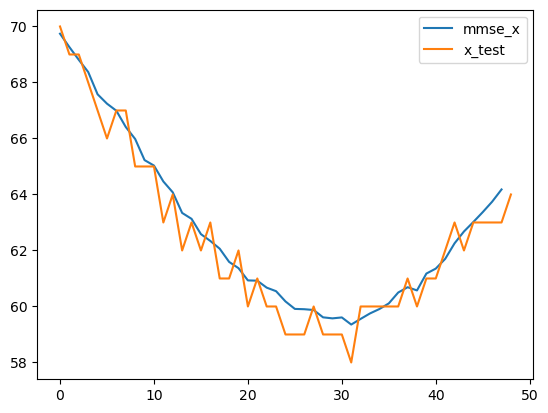

In [11]:
# lateral position X
plt.plot(mmse_x)
plt.plot(x_test[1:])
plt.legend(['mmse_x', 'x_test'])


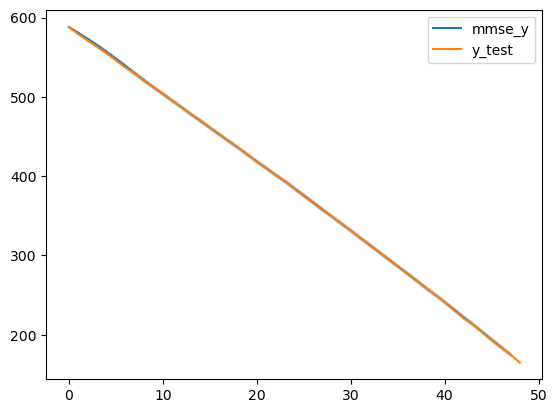

In [12]:
# longitudinal position Y
plt.plot(mmse_y)
plt.plot(y_test[1:])
# draw confidence interval 
plt.fill_between(np.arange(mmse_y.shape[0]), mmse_y - 2 * mmse_y_std, mmse_y + 2 * mmse_y_std, alpha=0.2)
plt.legend(['mmse_y', 'y_test'])


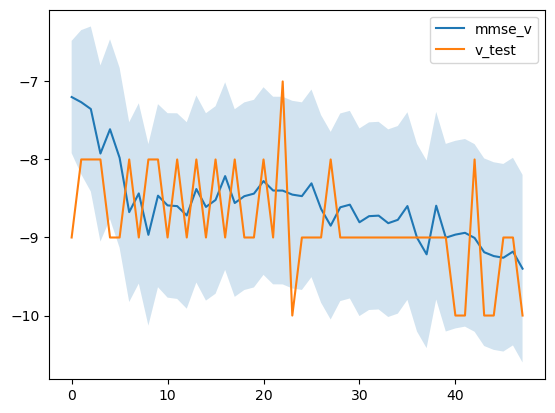

In [13]:
# velocity v 
plt.plot(mmse_v)
plt.plot(y_test[2:] - y_test[1:-1])
# draw confidence interval
plt.fill_between(np.arange(mmse_v.shape[0]), mmse_v - 2 * mmse_v_std, mmse_v + 2 * mmse_v_std, alpha=0.2)
plt.legend(['mmse_v', 'v_test'])

# Smoothing

In [14]:
# clone smoothie for easy debugging
import copy
smoothicc = copy.deepcopy(smoothie)
smoothicc.init_smoothie()
print('Cloning successful!')

Cloning successful!


In [15]:
#for bk in range(smoothicc.t): # first iteration is from N-1
xs_log = [] # first element corresponds to N-1 !!!
ps_log = []
ws_log = []
for bk in range(smoothicc.t):
    k = smoothicc.t - bk - 1
    print('Loop\'s k = ', k, ', t_s = ', smoothicc.t_s)
    print('At k+1 = ', k+1, ', measurement is ', x_test[k+1])
    print('At k = ', k, ', measurement is ', x_test[k])
    xs, ps, ws, dbgObj = smoothicc.smooth_measurement(x_test[k+1]) # first measurement will be x_test[N] 
    xs_log.append(xs)
    ps_log.append(ps)
    ws_log.append(ws)
    # *** For debugging ***
    if bk == 3:
        break
    print('------------------')


Loop's k =  47 , t_s =  47
At k+1 =  48 , measurement is  63.0
At k =  47 , measurement is  63.0
SmoothIE's k =  47
********************************
*** After measurement update ***
P_kPlus1_kPlus1 =  [9.]
mu_kPlus1_kPlus1 =  [63.]
********************************
*** After backward prediction ***
L_k_kPlus1 =  [0.11098779 0.11098779 0.11098779]
s_k_kPlus1 =  [-7.08842027 -6.92193859 -6.7554569 ]
t_k_kPlus1 =  [463.72036382 436.92408202 422.1887323 ]
*** After backward prediction ***
P_k_kPlus1 =  [9.01 9.01 9.01]
mu_k_kPlus1 =  [63.86666667 62.36666667 60.86666667]
w_k_kPlus1 =  [0.05 0.9  0.05]
Number of components pruned at LV1:  0
Number of components pruned at LV2:  0
********************************
*** After pruning of mixture components ***
P_k_kPlus1 =  [9.01 9.01 9.01]
mu_k_kPlus1 =  [63.86666667 62.36666667 60.86666667]
w_k_kPlus1 =  [0.05 0.9  0.05]
Expectation:  62.366666666659626
*** Filter state for fusion ***
index_of_array_of_filter =  46
x_filter =  [63.88904717 65.54

# Debugging *

In [28]:
L1 = dbgObj[0]
s1 = dbgObj[1]
t1 = dbgObj[2]
L2 = dbgObj[3]
s2 = dbgObj[4]
t2 = dbgObj[5]

In [29]:
mu1, P1, w1 = infoToState(L1, s1, t1)
mu2, P2, w2 = infoToState(L2, s2, t2)

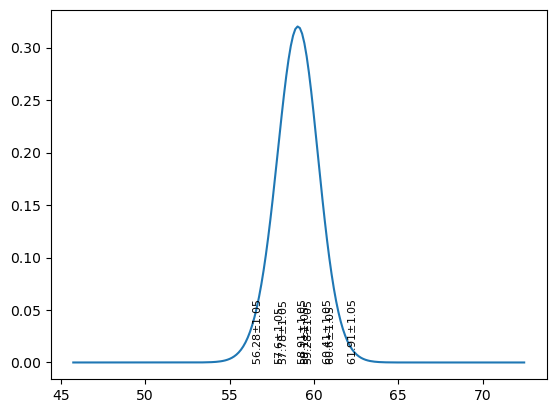

In [31]:
plot_gmm_information(L1, s1, t1)

Resample by EM

In [32]:
particle_modes = np.random.choice(w1.shape[0], 20_000, p=np.exp(w1))
particles = np.random.normal(mu1[particle_modes], np.sqrt(P1[particle_modes]))

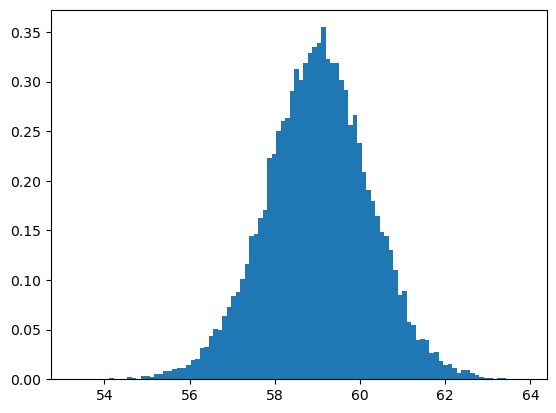

In [34]:
plt.hist(particles, bins=100, density=True)
plt.show()

# Plot the smoothed results

In [ ]:
mmse_x_smooth = np.zeros(output_length)
# reverse the log variables
xs_log_reverse = xs_log[::-1]
ps_log_reverse = ps_log[::-1]
ws_log_reverse = ws_log[::-1]

# compute the mmse 
for i in range(output_length):
    mmse_x_smooth[i] = np.sum(np.array(ws_log_reverse[i]) * np.array(xs_log_reverse[i]))

In [ ]:
plt.plot(mmse_x)
plt.plot(x_test[1:])
plt.plot(mmse_x_smooth)
plt.plot(x_mean + mmse_x_smooth[-1] - x_mean[-2])
plt.legend(['mmse_x', 'x_test', 'mmse_x_smooth', 'x_mean'])